Расчёт доходности порфеля на основе ежемесячных отчетов брокера "Сбербанк Инвестор"

In [1]:
import os
import numpy as np
import pandas as pd
import pandas_datareader
import pandas_datareader.moex as moex
from lxml import etree, html
from lxml.etree import tostring
import re
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200
pd.set_option('display.max_rows', None)

In [2]:
sber_date_format = '%d.%m.%Y'

h1 = {
    'Торговая площадка': 'section',
    'Оценка портфеля ЦБ, руб.': 'cost',
    'Денежные средства, руб.': 'cash',
    'Оценка, руб.': 'all_cost',
    'Дата': 'date',
    'Описание операции': 'operation',
    'Валюта': 'currency',
    'Сумма зачисления': 'inflow',
    'Сумма списания': 'outflow',
    'Сумма': 'cash',
    'Наименование': 'shortname',
    'ISIN ценной бумаги': 'ISIN',
    'Валюта рыночной цены': 'currency',
    'Количество, шт': 'count',
    'Номинал*': 'value',
    'Рыночная цена **': 'market_price',
    'Рыночная стоимость, без НКД***': 'market_price2',
    'НКД****':'interest'}

In [3]:
def asset_valuation(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0)[0]
    #df = df[:-1]
    df.rename(columns=h1, inplace=True)
    for h in ['cost', 'cash', 'all_cost']:
        if (df[h].dtype != np.float64):
            df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df['contract'] = cc
    df['date'] = ed
    return df


def ind_inv_account(t, cc, sd, ed):
    return None


def securities_portfolio(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0, skiprows=[0,2])[0]
    df.rename(columns=h1, inplace=True)
    df_1 = df.iloc[:,[0,1,2,3,4,5,6,7]].copy()
    df_2 = df.iloc[:,[0,1,2,8,9,10,11,12]].copy()
    df_2.columns=df_1.columns

    df_1['date'] = sd
    df_2['date'] = ed
    df = df_1.append(df_2)
    df['contract'] = cc
    df.set_index(['date', 'contract', 'ISIN'], inplace=True)
    #df['count'] = df['count'].astype(str)
    for h in ['count','value', 'market_price', 'market_price2', 'interest']:
        #if (np.issubdtype(df[h].dtype , np.number) is not True):
        df[h] = df[h].astype(str)
        df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df = df[df['count']>0]
    return df


def cash(t, cc, sd, ed):
    return None


def flow_of_funds(t, cc, sd, ed):
    t.remove(t[-1])
    df = pd.read_html(tostring(t), header=0)[0]
    #df = df[:-1]
    df.rename(columns=h1, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format=sber_date_format)
    for h in ['inflow', 'outflow']:
        if (df[h].dtype != np.float64):
            df[h] = pd.to_numeric(df[h].str.replace(' ', ''))
    df['contract'] = cc
    return df


def deals(t, cc, sd, ed):
    return None


def repos(t, cc, sd, ed):
    return None


def payouts(t, cc, sd, ed):
    df = pd.read_html(tostring(t), header=0)[0]
    df.rename(columns=h1, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format=sber_date_format)
    if (df['cash'].dtype != np.float64):
        df['cash'] = df['cash'].str.replace(' ', '')
        df['cash'] = pd.to_numeric(df['cash'])
    df['contract'] = cc
    return df


def securities_directory(t, cc, sd, ed):
    return None


table_names = {
    'Оценка активов': asset_valuation,
    'Информация о зачислениях денежных средств на ИИС': ind_inv_account,
    'Портфель Ценных Бумаг': securities_portfolio,
    'Денежные средства': cash,
    'Движение денежных средств за период': flow_of_funds,
    'Сделки купли/продажи ценных бумаг': deals,
    'Сделки РЕПО': repos,
    'Выплаты дохода от эмитента на внешний счет': payouts,
    'Справочник Ценных Бумаг**': securities_directory}


def load_reports(file_paths):
    tbls = {}

    date_pattern = re.compile(r'за период с ([0-9.]+) по ([0-9.]+), дата создания ([0-9.]+)')
    contract_pattern = re.compile(' [0-9A-Z]{5,10} ')

    for file_path in file_paths:
        #print(f'Файл {file_path}')
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as report_file:
            htmlstr = report_file.read()

        root = html.fromstring(htmlstr)
        test = root.xpath('/html/body/h3')

        string = test[0].text_content()
        match = date_pattern.search(string)
        start_date = dt.datetime.strptime(match[1], sber_date_format)
        #start_date = start_date.replace(hour=9, minute=55)
        end_date = dt.datetime.strptime(match[2], sber_date_format)
        #end_date= end_date.replace(hour=18, minute=55)
        report_date = dt.datetime.strptime(match[3], sber_date_format)

        pp_str = root.xpath('/html/body/p[1]')[0].text_content()
        contract_code = contract_pattern.search(pp_str)[0].replace(' ', '')
        html_tbls = zip(root.xpath('/html/body/p')[1:-1],
                        root.xpath('/html/body/table')[:-1])

        for p, t in html_tbls:
            str = p.text_content()
            str = str.lstrip('\n').split('\n')[0]
            func = table_names.get(str)
            if func:
                df = tbls.get(str)
                if df is not None:
                    tbls[str] = df.append(func(t, contract_code, start_date, end_date))
                else:
                    tbls[str] = func(t, contract_code, start_date, end_date)

        #print(f'Отчет за период {start_date}-{end_date} от {report_date} загружен')
    return tbls

def modified_dietz(df):
    return 0

def load_benchmarks(benchmarks, first='2019-08-01', end='2020-07-31'):
    
    sdate = dt.datetime(2019,8,1)
    edate = dt.datetime.today()
    dfs = {}
    for benchmark in benchmarks:
        df = pandas_datareader.DataReader(benchmark, 'moex', start=sdate, end=edate)
        df = df[df['BOARDID']=='TQTF']
        #print(df)
        df['TRADEDATE'] = pd.to_datetime(df.index)
        per_bb = df['TRADEDATE'].dt.to_period("M")
        g = df.groupby(per_bb)['WAPRICE'].mean()
        #g.rename({'TRADEDATE': 'date','WAPRICE':'sbmx'}, inplace=True)
        dfs[benchmark] = g

    #print(dfs)
    return dfs

In [4]:
benchmarks = load_benchmarks(['SBMX', 'FXUS'])
benchmarks['FXUS']

TRADEDATE
2019-08    3394.863636
2019-09    3438.285714
2019-10    3403.625000
2019-11    3530.200000
2019-12    3558.318182
2020-01    3625.500000
2020-02    3769.526316
2020-03    3511.409091
2020-04    3712.818182
2020-05    3821.450000
2020-06    3885.750000
2020-07    4161.217391
2020-08    4518.388889
Freq: M, Name: WAPRICE, dtype: float64

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.03, 0.8, 'Mod. Dieatz = 20.4%')

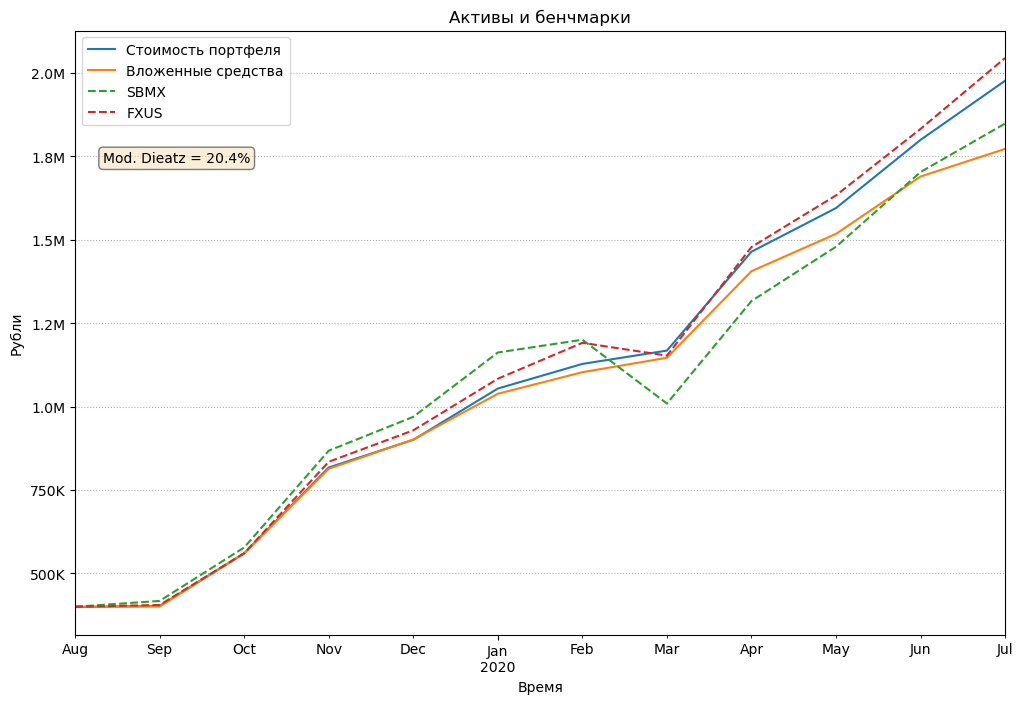

In [5]:
path = 'sber_reports/'
arr = [path + f for f in os.listdir(path) if f.endswith('.html')]
dfs = load_reports(arr)
aa = dfs['Оценка активов']
per_aa = aa.date.dt.to_period('M')
g1 = aa.groupby(per_aa).sum()

bb = dfs['Движение денежных средств за период']
bb = bb[bb.operation == 'Зачисление д/с']
per_bb = bb.date.dt.to_period("M")

g2 = bb.groupby(per_bb).sum()

cc = dfs['Выплаты дохода от эмитента на внешний счет']
per_cc = cc.date.dt.to_period("M")
g3 = cc.groupby(per_cc).sum()

gg = g2[['inflow']].join(g3, how='left')
gg = g1[['all_cost']].join(gg, how='left')
gg.fillna(0, inplace=True)
gg.loc['2020-04']['cash'] += 52000

gg['inflow'] -= gg['cash']

from operator import attrgetter
# Modified Dietz
gg['period'] = (gg.index.to_series() - gg.index[0]).apply(attrgetter('n'))
gg['period'] = 1 - gg['period'] / gg.iloc[-1]['period']
gg.loc[gg.index[-1], 'period']= 1/12/2
gg['waf'] = gg['inflow'] * gg['period']

gg['cum_inflow'] = gg['inflow'].cumsum()
ModDietz = (gg.iloc[-1]['all_cost'] - gg.iloc[-1]['cum_inflow']) / gg['waf'].sum()

benchmarks = load_benchmarks(['SBMX', 'FXUS'])
gg['sbmx_price']=benchmarks['SBMX']
# С учётом суммарн6ой комисии 0.1%
gg['sbmx_stocks'] = (gg['inflow'] / gg['sbmx_price']) * (1-0.001)
gg['sbmx'] = gg['sbmx_stocks'].cumsum() * gg['sbmx_price']

gg['fxus_price']=benchmarks['FXUS']
# С учётом суммарн6ой комисии 0.1%
gg['fxus_stocks'] = (gg['inflow'] / gg['fxus_price']) * (1-0.001)
gg['fxus'] = gg['fxus_stocks'].cumsum() * gg['fxus_price']

pf_df = dfs['Портфель Ценных Бумаг']


ax1 = gg[['all_cost', 'cum_inflow', 'sbmx', 'fxus']].plot(style=['-','-','--', '--'])
ax1.grid(axis='y', linestyle=':')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
mkfunc = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.0fK' % (x * 1e-3) if x >= 1e3 else '%1.1f' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)
ax1.yaxis.set_major_formatter(mkformatter)
ax1.set_ylabel('Рубли')
ax1.set_xlabel('Время')
ax1.legend(['Стоимость портфеля', 'Вложенные средства', 'SBMX', 'FXUS'])
ax1.set_title(f'Активы и бенчмарки')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.03, 0.8, f"Mod. Dieatz = {ModDietz * 100:.1f}%", transform=ax1.transAxes,
    verticalalignment='top', bbox=props)
#plt.show()